In [1]:
import cymetric as cym
import pandas as pd
import sklearn as skl

import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40,24)
from cymetric import graphs as cgr
from cymetric import timeseries as tm
from cymetric import filters as fl

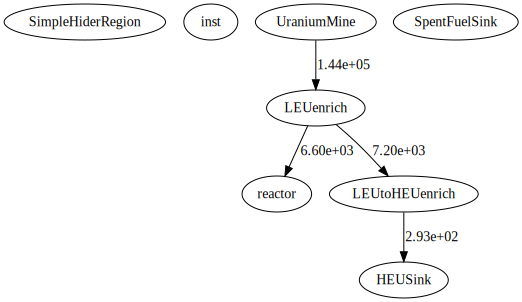

In [2]:
file = "simple/out-run7.py-.sqlite"
db = cym.dbopen(file)
ev = cym.Evaluator(db=db, write=True)
cym.graphs.flow_graph(ev, label = "mass")

#### extract data from the sqlite file

In [141]:
def tidy_df(file):
    db = cym.dbopen(file)
    ev = cym.Evaluator(db=db, write=True)
    
    agentTable = ev.eval("AgentEntry")
    try: 
        agents = agentTable.loc[:, ["AgentId", "Prototype"]]
    except: 
        print("there was an agent issue with " + file)
    
    transTable = ev.eval("Transactions")
    try: 
        transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
    except: 
        print("there was an transactions issue with " + file)
    
    resourceTable = ev.eval("Resources")
    try: 
        resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
    except:
        print("there was a resources issue with " + file)
    
    #merge agents, transactions, and resources
    int1 = pd.merge(transactions, resources, on='ResourceId', how='inner')

    #rename AgentId column to facilitate merge 
    send = agents.rename(columns = {"AgentId": "SenderId"})
    receive = agents.rename(columns = {"AgentId": "ReceiverId"})

    for i in range(len(int1)):
        for j in range(len(send)):
            if int1.loc[i,"SenderId"] == send.loc[j, "SenderId"]:
                int1.loc[i,"SenderId"] = send.loc[j, "Prototype"]
                
    for i in range(len(int1)):
        for j in range(len(receive)):
            if int1.loc[i,"ReceiverId"] == receive.loc[j, "ReceiverId"]:
                int1.loc[i,"ReceiverId"] = receive.loc[j, "Prototype"]

#     print("tidy_df output")
#     print(int1)
    return int1
    

#### trim resource-identifying columns

In [4]:
def trim_data(df):
    trimmed = df[["SenderId", "ReceiverId", "Time", "Quantity"]]
    trimmed["fraction"] = pd.Series(0, index = range(316)) #modular? 
    trimmed["truck"] = pd.Series(0, index = range(316))
    
    #assume leu and heu enrichment happens in the same physical facility
    #drop rows with transactions between enrichment facilities
    short = trimmed.loc[(trimmed['SenderId'] != "LEUenrich") & (trimmed['ReceiverId'] != "LEUtoHEUenrich")]
    
    #change the name of enrichment facilites 
    short["SenderId"] = short['SenderId'].replace({'LEUenrich': 'enrichment', 'LEUtoHEUenrich': 'enrichment'})
    short['ReceiverId'] = short['ReceiverId'].replace({'LEUenrich': 'enrichment', 'LEUtoHEUenrich': 'enrichment'})
    
    return short

#### define truck

for each transaction, cap shipment at a certain mass m ( = 25000kg? is realisitc, but a smaller value might be more interesting)
create a new column with the number of trucks sent for this interaction (0 + )
consider storing heu for several timesteps


In [5]:
from collections import Counter
def send_trucks(truck_df, truck_size): 
    truck_df["fraction"] = truck_df["Quantity"] / truck_size #reevaluate this if you want the trucks to have different capacities
    
    #collect set of all transaction types: 
    transaction_pairs = Counter()
    for i in range(len(truck_df)): 
        #add this transaction to the counter
        #check if the value for that type of transaction is greater than the value for the truck 
        #if so, send a truck and update the value for the transaction type
        #if not, update the value for the transaction type 
        #0: senderid, 1: receiverid, 2: time, 3: quantity, 4: fraction, 5: truck
        sender = truck_df.iloc[i, 0]
        receiver = truck_df.iloc[i, 1]
        transaction_pairs.update({(sender, receiver): truck_df.iloc[i, 3]})
        stored_material = transaction_pairs[(sender, receiver)]
        if stored_material >= truck_size: 
            trucks = stored_material // truck_size
            truck_df.at[i, "truck"] = trucks
            transaction_pairs[(sender, receiver)] -= trucks * truck_size
        else: 
            truck_df.at[i, "truck"] = 0
        
            
    print(transaction_pairs)
    print(truck_df)
        
    return truck_df
    

#### flatten data into single row for use with other runs

columns: every perumutation of transaction (truck boolean), every timestamp

row: single cyclus run 

transactions: mine to enrichment, enrichment to reactor, reactor to sf sink, enrichment to heu sink

In [272]:
def make_cols(max_time):
    col_names = ["diversion"]
    #edit so that transactions include all but the heu going to the heusink 
#     transactions = {("UraniumMine", "enrichment"), ("enrichment", "reactor"), 
#                     ("reactor", "SpentFuelSink"), }#("enrichment", "HEUSink")}
    #["mine--enrich", "enrich--reactor", "enrich--heusink", "reactor--sfsink"]
#         ('milling', 'conversion'),('mil_enrichment', 'mil_str_u_dep'),('civ_enrichment', 'civ_str_u_dep'), 
#         ('conversion', 'mil_uox_fabrication'), ('civ_enrichment', 'civ_fabrication'), 
#         ('mine', 'milling'), ('conversion', 'civ_enrichment'), ('mil_enrichment', 'mil_str_fiss'), 
#         ('conversion', 'mil_enrichment')
    transactions = {
          ('civ_enrichment', 'civ_str_u_dep'), ('mine', 'milling'), ('milling', 'conversion'), 
          ('civ_enrichment', 'civ_fabrication'), ('conversion', 'civ_enrichment')
    }
    
    for t in range(max_time):
        for trans in sorted(transactions): 
            col_names.append(trans[0] + "--" + trans[1] + "|time" + str(t))
    return col_names
 
def make_row(truckdf, max_time):
    long_row = []
    #long_row.append("HEUSink" in truckdf["ReceiverId"].tolist())
    long_row.append("mil_enrichment" in truckdf["ReceiverId"].tolist())
    # mil_enrichment
#         ('milling', 'conversion'),('mil_enrichment', 'mil_str_u_dep'),('civ_enrichment', 'civ_str_u_dep'), 
#         ('conversion', 'mil_uox_fabrication'), ('civ_enrichment', 'civ_fabrication'), 
#         ('mine', 'milling'), ('conversion', 'civ_enrichment'), ('mil_enrichment', 'mil_str_fiss'), 
#         ('conversion', 'mil_enrichment')
    transactions = {
        #("UraniumMine", "enrichment"), ("enrichment", "reactor"), 
                    #("reactor", "SpentFuelSink"), #("enrichment", "HEUSink")
           ('civ_enrichment', 'civ_str_u_dep'), ('mine', 'milling'), ('milling', 'conversion'), 
           ('civ_enrichment', 'civ_fabrication'), ('conversion', 'civ_enrichment')
    }
    sorted_trans = sorted(transactions)
    for t in range(max_time):
        #subset rows with this timestep
        subset = truckdf.loc[truckdf['Time'] == t]
        sub_row = [0] * len(transactions)
        
        for index, row in subset.iterrows():
            #check each possible transaction
            for t in range(len(transactions)): 
                if row["SenderId"] == sorted_trans[t][0] and row["ReceiverId"] == sorted_trans[t][1]:    
                    sub_row[t] = truckdf.loc[index, "truck"]
#             if row["SenderId"] == "UraniumMine" and row["ReceiverId"] == "enrichment":
#                 #sub_row[0] = ("mine--enrich") #switch to the number of trucks sent!
#                 sub_row[0] = truckdf.loc[index, "truck"]
                
#             if row["SenderId"] == "enrichment" and row["ReceiverId"] == "reactor":
#                 sub_row[1] = truckdf.loc[index, "truck"]

#             if row["SenderId"] == "enrichment" and row["ReceiverId"] == "HEUSink":
#                 sub_row[2] = truckdf.loc[index, "truck"]

#             if row["SenderId"] == "reactor" and row["ReceiverId"] == "SpentFuelSink":
#                 sub_row[3] = truckdf.loc[index, "truck"]
        long_row.extend(sub_row)
    return long_row

In [143]:
def file_to_line(filename, truck_size, max_time):
    return make_row(send_trucks(trim_data(tidy_df(filename)), truck_size), max_time)
    
def simulation_data(files, truck_size, max_time):
    columns = make_cols(max_time)
    rows = []
    for file in files: 
        rows.append(file_to_line(file, truck_size, max_time))
    return pd.DataFrame(data = rows, columns = columns)

In [144]:
simulation_data(["0309base.sqlite", "0309reactor4.sqlite"], 12000, 144)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/local/Library/Frameworks/Python.framework/Versions/3.6

Counter({('reactor', 'SpentFuelSink'): 6900.0, ('enrichment', 'HEUSink'): 292.86510590858416, ('UraniumMine', 'enrichment'): 0.0})
        SenderId  ReceiverId  Time      Quantity  fraction  truck
0    UraniumMine  enrichment   0.0  10000.000000  0.833333    0.0
1    UraniumMine  enrichment   1.0  10000.000000  0.833333    1.0
3     enrichment     HEUSink   2.0      4.124861  0.000344    1.0
4    UraniumMine  enrichment   2.0  10000.000000  0.833333    1.0
5    UraniumMine  enrichment   3.0  10000.000000  0.833333    0.0
..           ...         ...   ...           ...       ...    ...
213          NaN         NaN   NaN           NaN       NaN    1.0
218          NaN         NaN   NaN           NaN       NaN    0.0
219          NaN         NaN   NaN           NaN       NaN    0.0
223          NaN         NaN   NaN           NaN       NaN    1.0
227          NaN         NaN   NaN           NaN       NaN    1.0

[292 rows x 6 columns]
Counter({('reactor', 'SpentFuelSink'): 6900.0, ('Uran

,diversion,UraniumMine--enrichment|time0,enrichment--reactor|time0,reactor--SpentFuelSink|time0,UraniumMine--enrichment|time1,enrichment--reactor|time1,reactor--SpentFuelSink|time1,UraniumMine--enrichment|time2,enrichment--reactor|time2,reactor--SpentFuelSink|time2,...,reactor--SpentFuelSink|time140,UraniumMine--enrichment|time141,enrichment--reactor|time141,reactor--SpentFuelSink|time141,UraniumMine--enrichment|time142,enrichment--reactor|time142,reactor--SpentFuelSink|time142,UraniumMine--enrichment|time143,enrichment--reactor|time143,reactor--SpentFuelSink|time143
0,True,0.0,0,0,1.0,0,0,1.0,0,0,...,0,0.0,0,0,0.0,0,0,0.0,0,0
1,False,0.0,0,0,1.0,0,0,1.0,0,0,...,0,0.0,0,0,0.0,0,0,0.0,0,0


In [279]:
#big_df = simulation_data(files[0:], 20000, 144)
#small_df = simulation_data(files[0:20], 20000, 144)
#med_df = simulation_data(files[0:100], 20000, 144)
#tweak = simulation_data(files[0:], 20000, 144)
#simple = simulation_data(files[0:], 20, 144)

import os
files = []
for file in os.listdir("swu_cycle_variance"):
    if file.endswith(".sqlite"):
        #print(file)
        #files.append(os.path.join("swu_cycle_variance", file))
        files.append(os.path.join("swu_cycle_variance", file))

print(files[0:10])
big_df = simulation_data(files[0:], 20000, 144)
#smaller_trucks = simulation_data(files[0:], 10000, 144)

['swu_cycle_variance/out-run290.py-.sqlite', 'swu_cycle_variance/out-run868.py-.sqlite', 'swu_cycle_variance/out-run384.py-.sqlite', 'swu_cycle_variance/out-run49.py-.sqlite', 'swu_cycle_variance/out-run590.py-.sqlite', 'swu_cycle_variance/out-run929.py-.sqlite', 'swu_cycle_variance/out-run484.py-.sqlite', 'swu_cycle_variance/out-run153.py-.sqlite', 'swu_cycle_variance/out-run631.py-.sqlite', 'swu_cycle_variance/out-run319.py-.sqlite']


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...
249      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390354, ('milling', 'conversion'): 10406.504065040848, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7029.686141401529, ('conversion', 'civ_enrichment'): 3902.4390243903617})
          SenderId      ReceiverId  Time      Quantity      fraction  truck
0             mine         milling     1  2.000000e+08  10000.000000  10000
1             mine         milling     2  1.515152e+08   7575.757576   7575
2          milling      conversion     2  1.500000e+05      7.500000      7
3             mine         milling     3  1.851749e+08   9258.744498   9259
4          milling      conversion     3  1.500000e+05      7.500000      8
..             ...             ...   ...           ...           ...    ...
74      conversion  civ_enrichment   134  1.640049e+04      0.820025      1
75  civ_enrichment   civ_str_u_dep   134  1.496981e+04      0.748491      1
76            mine         milling   135  5.252202e+07   262

Counter({('conversion', 'mil_enrichment'): 19607.06533681431, ('milling', 'conversion'): 19308.19971064299, ('mil_enrichment', 'mil_str_u_dep'): 18329.03973159586, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024391031, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 5907.82141661644, ('conversion', 'civ_enrichment'): 3902.439024391024, ('mil_enrichment', 'mil_str_fiss'): 1296.2831138644128})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...         

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390595, ('mine', 'milling'): 10681.132322758436, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798846, ('conversion', 'civ_enrichment'): 3902.4390243905873, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
257    

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
255      

Counter({('milling', 'conversion'): 16585.750935664662, ('conversion', 'mil_enrichment'): 16177.127654121068, ('mil_enrichment', 'mil_str_u_dep'): 15646.106223372108, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902438858, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('mine', 'milling'): 5485.102615594864, ('conversion', 'civ_enrichment'): 3902.439024388579, ('mil_enrichment', 'mil_str_fiss'): 538.6074511883216})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...      

Counter({('mine', 'milling'): 18642.946930214763, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439034, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 6981.485197613976, ('milling', 'conversion'): 6823.855849101208, ('mil_enrichment', 'mil_str_u_dep'): 5852.58431766947, ('conversion', 'civ_enrichment'): 3902.43902439034, ('mil_enrichment', 'mil_str_fiss'): 1145.028035372278})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...       

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439031, ('milling', 'conversion'): 10406.504065040732, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390311, ('mine', 'milling'): 2200.4333324581385})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439042, ('milling', 'conversion'): 11878.878559455006, ('conversion', 'mil_enrichment'): 11449.790615404017, ('mil_enrichment', 'mil_str_u_dep'): 10940.376856738329, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.43902439042, ('mine', 'milling'): 3201.3835327476263, ('mil_enrichment', 'mil_str_fiss'): 516.6910980752367})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...   

Counter({('mine', 'milling'): 16293.334583863616, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024392857, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 8401.317340111957, ('conversion', 'mil_enrichment'): 8044.06608640957, ('mil_enrichment', 'mil_str_u_dep'): 7458.803354018971, ('conversion', 'civ_enrichment'): 3902.439024392872, ('mil_enrichment', 'mil_str_fiss'): 593.6236285675066})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...     

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
256    

Counter({('conversion', 'mil_enrichment'): 19999.999999999985, ('mil_enrichment', 'mil_str_u_dep'): 16800.445930880785, ('mine', 'milling'): 16545.855667114258, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390631, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 4676.327236014724, ('conversion', 'civ_enrichment'): 3902.439024390631, ('mil_enrichment', 'mil_str_fiss'): 3276.0102700679827})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ... 

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390893, ('mine', 'milling'): 10681.132323488593, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799319, ('conversion', 'civ_enrichment'): 3902.4390243909, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
261      c

Counter({('milling', 'conversion'): 19798.400344275375, ('mil_enrichment', 'mil_str_u_dep'): 16800.44593088072, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390922, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 8872.178167656064, ('conversion', 'civ_enrichment'): 3902.4390243909293, ('mil_enrichment', 'mil_str_fiss'): 3253.937243029439, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390136, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7956.802909344435, ('milling', 'conversion'): 7449.041861761769, ('conversion', 'mil_enrichment'): 7435.476366851162, ('mil_enrichment', 'mil_str_u_dep'): 6487.332049009369, ('conversion', 'civ_enrichment'): 3902.439024390129, ('mil_enrichment', 'mil_str_fiss'): 961.6892366681057})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...     

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390645, ('mine', 'milling'): 10681.132322847843, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798912, ('conversion', 'civ_enrichment'): 3902.4390243906455, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
252    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 17882.064377740026, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390296, ('milling', 'conversion'): 10406.504065040732, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.4390243903035})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   12

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390376, ('milling', 'conversion'): 10406.50406504082, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243903763, ('mine', 'milling'): 3280.72628813982})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+

Counter({('milling', 'conversion'): 18018.073669048492, ('conversion', 'mil_enrichment'): 17789.590921125975, ('mil_enrichment', 'mil_str_u_dep'): 17068.367595845408, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390376, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 6120.0152878165245, ('conversion', 'civ_enrichment'): 3902.4390243903617, ('mil_enrichment', 'mil_str_fiss'): 731.5265156416582})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390322, ('milling', 'conversion'): 10406.50406504076, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 4791.524850964546, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId     ReceiverId  Time      Quantity      fraction  truck
0             mine        milling     1  2.000000e+08  10000.000000  10000
1             mine        milling     2  1.515152e+08   7575.757576   7575
2          milling     conversion     2  1.500000e+05      7.500000      7
3             mine        milling     3  1.851749e+08   9258.744498   9259
4          milling     conversion     3  1.500000e+05      7.500000      8
..             ...            ...   ...           ...           ...    ...
64  civ_enrichment  civ_str_u_dep   132  1.206029e+04      0.603014      0
65            mine        milling   133  6.290439e+07   3145.219551   3146
66         milling     conversion   133  1.542295e+03      0

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390704, ('mine', 'milling'): 10119.611860826612, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390711, ('conversion', 'mil_enrichment'): 3360.656178141573, ('mil_enrichment', 'mil_str_fiss'): 2519.0681161563457, ('milling', 'conversion'): 1920.000115427756, ('mil_enrichment', 'mil_str_u_dep'): 877.0678946071312})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390442, ('mine', 'milling'): 12083.89230261743, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 4469.281216464824, ('milling', 'conversion'): 4409.107296441754, ('conversion', 'civ_enrichment'): 3902.439024390442, ('mil_enrichment', 'mil_str_u_dep'): 3443.278927738383, ('mil_enrichment', 'mil_str_fiss'): 1040.6594642795478})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390485, ('mine', 'milling'): 11365.68418905139, ('milling', 'conversion'): 10406.504065040877, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243904927})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 16366.043129712343, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390747, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243907474, ('milling', 'conversion'): 3695.524765798502, ('conversion', 'mil_enrichment'): 3665.639631340837, ('mil_enrichment', 'mil_str_u_dep'): 2734.7264513090413, ('mil_enrichment', 'mil_str_fiss'): 944.2119397465103})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...  

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390544, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 8700.21784089951, ('conversion', 'mil_enrichment'): 8431.222676332392, ('mine', 'milling'): 8412.453014671803, ('mil_enrichment', 'mil_str_u_dep'): 7752.7745013345575, ('conversion', 'civ_enrichment'): 3902.4390243905436, ('mil_enrichment', 'mil_str_fiss'): 688.1402917834101})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390762, ('mine', 'milling'): 11319.082837313414, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'mil_enrichment'): 7598.545580220294, ('milling', 'conversion'): 6485.864022259368, ('mil_enrichment', 'mil_str_u_dep'): 5461.250109898239, ('conversion', 'civ_enrichment'): 3902.439024390762, ('mil_enrichment', 'mil_str_fiss'): 2167.828262755248})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...        

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 15735.160750985146, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390413, ('milling', 'conversion'): 10406.50406504079, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.43902439042})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+

Counter({('conversion', 'mil_enrichment'): 16445.19161283101, ('milling', 'conversion'): 16333.173924857547, ('mil_enrichment', 'mil_str_u_dep'): 15364.449934333072, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4814.8429809212685, ('conversion', 'civ_enrichment'): 3902.4390243903254, ('mil_enrichment', 'mil_str_fiss'): 1096.1808453335723})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390362, ('mine', 'milling'): 11692.897846460342, ('milling', 'conversion'): 10406.504065040703, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'civ_enrichment'): 3902.4390243903763})
          SenderId     ReceiverId  Time      Quantity      fraction  truck
0             mine        milling     1  2.000000e+08  10000.000000  10000
1          milling     conversion     2  1.500000e+05      7.500000      7
2             mine        milling     2  1.515152e+08   7575.757576   7575
3          milling     conversion     3  1.500000e+05      7.500000      8
4             mine        milling     3  1.851749e+08   9258.744498   9259
..             ...            ...   ...           ...           ...    ...
70  civ_enrichment  civ_str_u_dep   133  1.938745e+04      0.969372      1
71         milling     conversion   134  1.963147e+04      0.981574      1
72         milling     conversion   134  1.823407e+03    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024391686, ('conversion', 'mil_enrichment'): 13757.670813085824, ('milling', 'conversion'): 12618.32637533023, ('mil_enrichment', 'mil_str_u_dep'): 11592.223265333707, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 5351.060125499964, ('conversion', 'civ_enrichment'): 3902.439024391686, ('mil_enrichment', 'mil_str_fiss'): 2196.3825127200066})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390238, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902526})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390238, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902526})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390645, ('mine', 'milling'): 10681.132322847843, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798904, ('conversion', 'civ_enrichment'): 3902.4390243906455, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...
253    

Counter({('mine', 'milling'): 15444.923688441515, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390405, ('milling', 'conversion'): 10406.504065040805, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390398})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
254      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('milling', 'conversion'): 18038.15401607228, ('mil_enrichment', 'mil_str_u_dep'): 16800.44593088078, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390922, ('mine', 'milling'): 13211.215420395136, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243909293, ('mil_enrichment', 'mil_str_fiss'): 3245.9719812165354, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390347, ('mine', 'milling'): 11852.11383008957, ('milling', 'conversion'): 10406.504065040732, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId     ReceiverId  Time      Quantity      fraction  truck
0             mine        milling     1  2.000000e+08  10000.000000  10000
1          milling     conversion     2  1.500000e+05      7.500000      7
2             mine        milling     2  1.515152e+08   7575.757576   7575
3          milling     conversion     3  1.500000e+05      7.500000      8
4             mine        milling     3  1.851749e+08   9258.744498   9259
..             ...            ...   ...           ...           ...    ...
92  civ_enrichment  civ_str_u_dep   137  1.935282e+04      0.967641      1
93            mine        milling   137  4.187191e+07   2093.595266   2094
94         milling     conversion   138  2.141655e+04      1.070828  

Counter({('mil_enrichment', 'mil_str_u_dep'): 19123.67691657176, ('mine', 'milling'): 14317.223690629005, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390667, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.439024390653, ('mil_enrichment', 'mil_str_fiss'): 1486.2790962100037, ('conversion', 'mil_enrichment'): 589.0225043843966, ('milling', 'conversion'): 112.74580822275311})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...      

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390937, ('mine', 'milling'): 12332.422151014209, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.439024390944, ('conversion', 'mil_enrichment'): 1242.4127339288607, ('mil_enrichment', 'mil_str_fiss'): 1211.1429582233911, ('milling', 'conversion'): 1023.0477683759382, ('mil_enrichment', 'mil_str_u_dep'): 48.32812722973904})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390347, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 8067.613400697708, ('conversion', 'civ_enrichment'): 3902.43902439034, ('conversion', 'mil_enrichment'): 3712.2437639126947, ('milling', 'conversion'): 2443.2258501776523, ('mil_enrichment', 'mil_str_fiss'): 2335.2545653714733, ('mil_enrichment', 'mil_str_u_dep'): 1409.8801079126679})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...  

Counter({('conversion', 'mil_enrichment'): 19999.999999999993, ('mil_enrichment', 'mil_str_u_dep'): 16800.445930880698, ('civ_enrichment', 'civ_str_u_dep'): 13902.4390243913, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024391286, ('mil_enrichment', 'mil_str_fiss'): 3260.3870532242017, ('mine', 'milling'): 2981.2380868196487, ('milling', 'conversion'): 1223.746425749836})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390304, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7627.6982928961515, ('milling', 'conversion'): 4779.712617817568, ('conversion', 'mil_enrichment'): 4754.5413435862065, ('conversion', 'civ_enrichment'): 3902.439024390311, ('mil_enrichment', 'mil_str_u_dep'): 3818.651020834111, ('mil_enrichment', 'mil_str_fiss'): 949.260184505781})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...    

Counter({('mine', 'milling'): 19889.39722749591, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390267, ('milling', 'conversion'): 10406.504065040703, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.4390243902453})
          SenderId     ReceiverId  Time      Quantity      fraction  truck
0             mine        milling     1  2.000000e+08  10000.000000  10000
1          milling     conversion     2  1.500000e+05      7.500000      7
2             mine        milling     2  1.515152e+08   7575.757576   7575
3          milling     conversion     3  1.500000e+05      7.500000      8
4             mine        milling     3  1.851749e+08   9258.744498   9259
..             ...            ...   ...           ...           ...    ...
82  civ_enrichment  civ_str_u_dep   135  2.097621e+04      1.048811      1
83         milling     conversion   136  1.493203e+04      0.746601      1
84         milling     conversion   136  8.281038e+03      

Counter({('conversion', 'mil_enrichment'): 17196.858637225167, ('milling', 'conversion'): 16042.625940488317, ('mil_enrichment', 'mil_str_u_dep'): 15015.691278905635, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024389983, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243899907, ('mine', 'milling'): 2913.5549043715, ('mil_enrichment', 'mil_str_fiss'): 2212.326892009814})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.445930880807, ('mine', 'milling'): 15800.980509892106, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390493, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 5156.63147282826, ('conversion', 'civ_enrichment'): 3902.4390243905, ('mil_enrichment', 'mil_str_fiss'): 3278.1836868987803, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...           ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439061, ('milling', 'conversion'): 10406.504065041008, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'civ_enrichment'): 3902.439024390631, ('mine', 'milling'): 2985.3857855200768})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121

Counter({('conversion', 'mil_enrichment'): 15402.408355547463, ('milling', 'conversion'): 14948.584534489419, ('mil_enrichment', 'mil_str_u_dep'): 13960.769699741752, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390973, ('mine', 'milling'): 13260.443191632628, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.4390243909656, ('mil_enrichment', 'mil_str_fiss'): 1462.233493745818})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390267, ('mine', 'milling'): 12279.356362372637, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243902744, ('milling', 'conversion'): 3519.0960634102084, ('conversion', 'mil_enrichment'): 3488.4438476376417, ('mil_enrichment', 'mil_str_u_dep'): 2558.340592592769, ('mil_enrichment', 'mil_str_fiss'): 943.3904444027282})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ... 

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 17655.10988113284, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390413, ('milling', 'conversion'): 10406.504065040906, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243904127})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390384, ('milling', 'conversion'): 10406.504065040674, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 6294.292795524001, ('conversion', 'civ_enrichment'): 3902.4390243903763})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390173, ('mine', 'milling'): 13687.794343233109, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'mil_enrichment'): 5874.356979193017, ('milling', 'conversion'): 3903.3385753485054, ('conversion', 'civ_enrichment'): 3902.4390243901653, ('mil_enrichment', 'mil_str_fiss'): 3087.052481551892, ('mil_enrichment', 'mil_str_u_dep'): 2830.7841100573387})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439038, ('milling', 'conversion'): 10406.50406504076, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 9380.206819847226, ('conversion', 'civ_enrichment'): 3902.4390243903836})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...
253      

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390638, ('mine', 'milling'): 10681.132322847843, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798912, ('conversion', 'civ_enrichment'): 3902.4390243906455, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
255    

Counter({('milling', 'conversion'): 17921.44355297384, ('mil_enrichment', 'mil_str_u_dep'): 16800.445930880807, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439114, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243911475, ('mine', 'milling'): 3739.2583111971617, ('mil_enrichment', 'mil_str_fiss'): 3245.4438566126123, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...           ...  

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390922, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.439024390922, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
261     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640798875, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390187, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 9432.293157626995, ('milling', 'conversion'): 9090.894077684934, ('mil_enrichment', 'mil_str_u_dep'): 8109.3584843311955, ('mine', 'milling'): 5611.21918335557, ('conversion', 'civ_enrichment'): 3902.4390243901944, ('mil_enrichment', 'mil_str_fiss'): 1341.8337400570983})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390806, ('milling', 'conversion'): 10406.504065041183, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 4642.125875502825, ('conversion', 'civ_enrichment'): 3902.4390243907983})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390791, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243907983, ('conversion', 'mil_enrichment'): 2054.4298995676763, ('mil_enrichment', 'mil_str_fiss'): 1956.6817095678289, ('mine', 'milling'): 1327.2710738927126, ('milling', 'conversion'): 1138.9090155482554, ('mil_enrichment', 'mil_str_u_dep'): 125.30708731770937})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...  

Counter({('mine', 'milling'): 19799.59044779837, ('conversion', 'mil_enrichment'): 14040.983891926637, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024389729, ('milling', 'conversion'): 13419.893510104506, ('mil_enrichment', 'mil_str_u_dep'): 12422.736362431737, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243897215, ('mil_enrichment', 'mil_str_fiss'): 1641.365351344797})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ... 

Counter({('conversion', 'mil_enrichment'): 16371.837794888972, ('milling', 'conversion'): 15394.336790112342, ('mil_enrichment', 'mil_str_u_dep'): 14377.273095937955, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024391715, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7981.21275728941, ('conversion', 'civ_enrichment'): 3902.4390243917005, ('mil_enrichment', 'mil_str_fiss'): 2023.058480364579})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...  

Counter({('mine', 'milling'): 15637.01263077557, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439269, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 5644.549089061373, ('conversion', 'mil_enrichment'): 5623.1379733981485, ('mil_enrichment', 'mil_str_u_dep'): 4683.277476529685, ('conversion', 'civ_enrichment'): 3902.43902439269, ('mil_enrichment', 'mil_str_fiss'): 953.2870753950651})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    .

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390434, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 9198.645827060756, ('mine', 'milling'): 8486.68495042622, ('milling', 'conversion'): 7472.976822143857, ('mil_enrichment', 'mil_str_u_dep'): 6414.1258182636775, ('conversion', 'civ_enrichment'): 3902.439024390442, ('mil_enrichment', 'mil_str_fiss'): 2824.2988660655706})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390347, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390347, ('conversion', 'mil_enrichment'): 1627.937935350259, ('mil_enrichment', 'mil_str_fiss'): 1583.8173711256654, ('mine', 'milling'): 1189.5047227442265, ('milling', 'conversion'): 1060.5836832097848, ('mil_enrichment', 'mil_str_u_dep'): 66.427851141867})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...    

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
258      

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640798875, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...

Counter({('mine', 'milling'): 18163.10882140696, ('conversion', 'mil_enrichment'): 15443.01630963693, ('milling', 'conversion'): 14902.436609989396, ('mil_enrichment', 'mil_str_u_dep'): 13909.776212792443, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390333, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243903326, ('mil_enrichment', 'mil_str_fiss'): 1555.1435267994168})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ... 

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('milling', 'conversion'): 19969.149863091123, ('conversion', 'mil_enrichment'): 19749.150055143476, ('mil_enrichment', 'mil_str_u_dep'): 19018.969993575854, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390413, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('mine', 'milling'): 4176.597923725843, ('conversion', 'civ_enrichment'): 3902.43902439042, ('mil_enrichment', 'mil_str_fiss'): 740.6112053042243})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...      

Counter({('conversion', 'mil_enrichment'): 17129.969373681397, ('milling', 'conversion'): 16062.606327436719, ('mil_enrichment', 'mil_str_u_dep'): 15040.523582787198, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439074, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 5957.895499676466, ('conversion', 'civ_enrichment'): 3902.43902439074, ('mil_enrichment', 'mil_str_fiss'): 2119.295016478396})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390573, ('milling', 'conversion'): 10406.504065041008, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4050.7711097449064, ('conversion', 'civ_enrichment'): 3902.4390243905873})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.00000

Counter({('mine', 'milling'): 17700.042629748583, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390493, ('milling', 'conversion'): 11075.943801628484, ('conversion', 'mil_enrichment'): 10991.19092384741, ('mil_enrichment', 'mil_str_u_dep'): 10118.210006581212, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.4390243904854, ('mil_enrichment', 'mil_str_fiss'): 885.452073227137})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...      

Counter({('mine', 'milling'): 19790.058368340135, ('milling', 'conversion'): 16695.571993082645, ('conversion', 'mil_enrichment'): 16374.382716133667, ('mil_enrichment', 'mil_str_u_dep'): 15751.043843072246, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024391853, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.4390243918606, ('mil_enrichment', 'mil_str_fiss'): 632.243714105216})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('conversion', 'mil_enrichment'): 16419.14138095088, ('milling', 'conversion'): 15268.275425583779, ('mil_enrichment', 'mil_str_u_dep'): 14241.528806076996, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390216, ('mine', 'milling'): 13294.09358599782, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390216, ('mil_enrichment', 'mil_str_fiss'): 2208.7213259435375})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...  

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
251    

Counter({('mine', 'milling'): 17630.63274604082, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439058, ('conversion', 'mil_enrichment'): 12380.780224976723, ('milling', 'conversion'): 11853.456958596274, ('mil_enrichment', 'mil_str_u_dep'): 10861.536970882666, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243905727, ('mil_enrichment', 'mil_str_fiss'): 1540.946729152585})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439023, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902453})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390573, ('mine', 'milling'): 12594.72326296568, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 6286.506776553564, ('conversion', 'mil_enrichment'): 6007.017216055461, ('mil_enrichment', 'mil_str_u_dep'): 5339.649578836114, ('conversion', 'civ_enrichment'): 3902.4390243905727, ('mil_enrichment', 'mil_str_fiss'): 676.901460608278})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390704, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390711, ('mine', 'milling'): 3731.7286675572395, ('milling', 'conversion'): 1379.1175877283677, ('conversion', 'mil_enrichment'): 1078.2915524959535, ('mil_enrichment', 'mil_str_fiss'): 654.0514519976358, ('mil_enrichment', 'mil_str_u_dep'): 433.4520927800004})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390398, ('mine', 'milling'): 11257.1051286906, ('milling', 'conversion'): 10406.50406504079, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'civ_enrichment'): 3902.439024390398})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439023, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902453})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390347, ('mine', 'milling'): 13378.064299628139, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 5722.721761000557, ('milling', 'conversion'): 5657.121691434091, ('mil_enrichment', 'mil_str_u_dep'): 4690.990256853331, ('conversion', 'civ_enrichment'): 3902.439024390369, ('mil_enrichment', 'mil_str_fiss'): 1046.4705256350892})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390398, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 6753.638000071049, ('conversion', 'civ_enrichment'): 3902.439024390391, ('conversion', 'mil_enrichment'): 3089.0080191667184, ('milling', 'conversion'): 2688.4889614697604, ('mil_enrichment', 'mil_str_u_dep'): 1703.6513492909035, ('mil_enrichment', 'mil_str_fiss'): 1405.1474794454434})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ... 

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
256    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439058, ('milling', 'conversion'): 10406.504065040994, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7820.502491846681, ('conversion', 'civ_enrichment'): 3902.43902439058})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+0

Counter({('mine', 'milling'): 17167.619356185198, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390413, ('milling', 'conversion'): 10406.504065040877, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.43902439042})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('mine', 'milling'): 13946.470887109637, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390362, ('milling', 'conversion'): 10406.50406504079, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390369})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('conversion', 'mil_enrichment'): 17246.228036840916, ('milling', 'conversion'): 15745.461273438908, ('mil_enrichment', 'mil_str_u_dep'): 14699.171699102842, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390282, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243902817, ('mine', 'milling'): 3823.438334211707, ('mil_enrichment', 'mil_str_fiss'): 2583.4428568486096})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...

Counter({('conversion', 'mil_enrichment'): 19871.364373515185, ('milling', 'conversion'): 19051.874076188702, ('mil_enrichment', 'mil_str_u_dep'): 18043.63572922154, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439077, ('mine', 'milling'): 10444.441482573748, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243907765, ('mil_enrichment', 'mil_str_fiss'): 1853.839053497852})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...  

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390857, ('mine', 'milling'): 12928.016211658716, ('conversion', 'mil_enrichment'): 11298.733509453883, ('milling', 'conversion'): 10170.033821928606, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('mil_enrichment', 'mil_str_u_dep'): 9144.525251495412, ('conversion', 'civ_enrichment'): 3902.439024390849, ('mil_enrichment', 'mil_str_fiss'): 2184.982661643604})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390338, ('mine', 'milling'): 11681.270287036896, ('milling', 'conversion'): 10406.50406504079, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'civ_enrichment'): 3902.439024390369})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439066, ('mine', 'milling'): 10681.132322892547, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798941, ('conversion', 'civ_enrichment'): 3902.439024390653, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
255      

Counter({('milling', 'conversion'): 18613.80797264377, ('mil_enrichment', 'mil_str_u_dep'): 16800.445930880815, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439106, ('mine', 'milling'): 12757.02548341453, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.439024391053, ('mil_enrichment', 'mil_str_fiss'): 3248.5768635016207, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...        

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
252    

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
252    

Counter({('mil_enrichment', 'mil_str_u_dep'): 19503.353891127368, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390347, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 4420.17326657474, ('conversion', 'civ_enrichment'): 3902.4390243903545, ('mil_enrichment', 'mil_str_fiss'): 1022.3097502153042, ('conversion', 'mil_enrichment'): 511.264912466464, ('milling', 'conversion'): 468.2252621574153})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...        

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390667, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 9729.252759179999, ('milling', 'conversion'): 8953.667706936889, ('mil_enrichment', 'mil_str_u_dep'): 7947.881592722219, ('mine', 'milling'): 6795.589588135481, ('conversion', 'civ_enrichment'): 3902.4390243906746, ('mil_enrichment', 'mil_str_fiss'): 1806.8193259786162})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...   

Counter({('conversion', 'mil_enrichment'): 15464.321180080484, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390704, ('milling', 'conversion'): 13365.207693115502, ('mil_enrichment', 'mil_str_u_dep'): 12285.49875328185, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390711, ('mil_enrichment', 'mil_str_fiss'): 3224.234175752849, ('mine', 'milling'): 1845.6405892074108})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('conversion', 'mil_enrichment'): 16842.562703216587, ('mine', 'milling'): 16481.233464330435, ('milling', 'conversion'): 16382.504447753003, ('mil_enrichment', 'mil_str_u_dep'): 15394.341402120504, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390245, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.439024390238, ('mil_enrichment', 'mil_str_fiss'): 1468.9101768260289})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024391148, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 4786.950923302549, ('milling', 'conversion'): 4638.8217231641465, ('conversion', 'civ_enrichment'): 3902.4390243911475, ('mil_enrichment', 'mil_str_u_dep'): 3668.0808020254535, ('mil_enrichment', 'mil_str_fiss'): 1134.8539801524666, ('mine', 'milling'): 609.6250263154507})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...    

Counter({('mine', 'milling'): 18930.066683858633, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390915, ('milling', 'conversion'): 10406.504065041285, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243909})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390238, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902526})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 19171.767118155956, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024391759, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024391766, ('milling', 'conversion'): 2597.5164323456265, ('conversion', 'mil_enrichment'): 2562.8573486104833, ('mil_enrichment', 'mil_str_u_dep'): 1636.9847564931551, ('mil_enrichment', 'mil_str_fiss'): 939.0993434333582})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...    

Counter({('mine', 'milling'): 19125.766715481877, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439035, ('milling', 'conversion'): 10406.50406504076, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'civ_enrichment'): 3902.4390243903545})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024391271, ('conversion', 'mil_enrichment'): 11499.395162747329, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('milling', 'conversion'): 9504.025944256282, ('mil_enrichment', 'mil_str_u_dep'): 8430.111416741467, ('mine', 'milling'): 5083.832177057862, ('conversion', 'civ_enrichment'): 3902.4390243912712, ('mil_enrichment', 'mil_str_fiss'): 3113.1306566630888})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390405, ('conversion', 'mil_enrichment'): 12840.950977521486, ('milling', 'conversion'): 11705.575023899757, ('mil_enrichment', 'mil_str_u_dep'): 10679.693565026706, ('mine', 'milling'): 10311.860826581717, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243904054, ('mil_enrichment', 'mil_str_fiss'): 2192.1325183875833})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ..

Counter({('mine', 'milling'): 18941.404524236917, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390434, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243904345, ('conversion', 'mil_enrichment'): 2682.437113049571, ('milling', 'conversion'): 2629.998448886123, ('mil_enrichment', 'mil_str_u_dep'): 1664.6021162117577, ('mil_enrichment', 'mil_str_fiss'): 1032.3754967926225})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390413, ('milling', 'conversion'): 10406.50406504079, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 9958.357185065746, ('conversion', 'civ_enrichment'): 3902.4390243904054})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('mine', 'milling'): 18641.617652490735, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390253, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 8913.258415708668, ('conversion', 'mil_enrichment'): 8732.14603625088, ('mil_enrichment', 'mil_str_u_dep'): 7960.90657276311, ('conversion', 'civ_enrichment'): 3902.4390243902453, ('mil_enrichment', 'mil_str_fiss'): 782.2571701091368})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...     

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.44593088077, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390478, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7487.629807174206, ('conversion', 'civ_enrichment'): 3902.439024390471, ('mil_enrichment', 'mil_str_fiss'): 3256.7838868377335, ('milling', 'conversion'): 427.48127456261136, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390602, ('milling', 'conversion'): 10406.504065041081, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('mine', 'milling'): 8934.414936929941, ('conversion', 'civ_enrichment'): 3902.4390243905873})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   12

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390558, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7077.570392337875, ('conversion', 'mil_enrichment'): 7062.389804082366, ('mine', 'milling'): 6204.104827225208, ('mil_enrichment', 'mil_str_u_dep'): 6115.950787140539, ('conversion', 'civ_enrichment'): 3902.439024390558, ('mil_enrichment', 'mil_str_fiss'): 959.9595743266186})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...     

Counter({('mine', 'milling'): 16827.739622429013, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040703, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId      ReceiverId  Time      Quantity      fraction  truck
0             mine         milling     1  2.000000e+08  10000.000000  10000
1          milling      conversion     2  1.500000e+05      7.500000      7
2             mine         milling     2  1.515152e+08   7575.757576   7575
3          milling      conversion     3  1.500000e+05      7.500000      8
4             mine         milling     3  1.851749e+08   9258.744498   9259
..             ...             ...   ...           ...           ...    ...
59      conversion  civ_enrichment   131  5.041027e+03      0.252051      1
60  civ_enrichment   civ_str_u_dep   131  4.601278e+03      0.230064      0
61         milling      conversion   132  5.0919

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439034, ('milling', 'conversion'): 11179.6507246275, ('conversion', 'mil_enrichment'): 10834.479181294919, ('mil_enrichment', 'mil_str_u_dep'): 10236.462052372566, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 5601.487567156553, ('conversion', 'civ_enrichment'): 3902.43902439034, ('mil_enrichment', 'mil_str_fiss'): 606.560230764053})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...       

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390238, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902526})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.44593088073, ('mine', 'milling'): 15917.633751407266, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243906164, ('mil_enrichment', 'mil_str_fiss'): 3265.211750992047, ('milling', 'conversion'): 2289.9582754055737, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...           ...  

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390267, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 8603.082991108298, ('conversion', 'civ_enrichment'): 3902.439024390267, ('conversion', 'mil_enrichment'): 1846.853476760516, ('milling', 'conversion'): 1711.4519711945904, ('mil_enrichment', 'mil_str_fiss'): 1121.2234280472203, ('mil_enrichment', 'mil_str_u_dep'): 741.4219279814824})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...       

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390376, ('milling', 'conversion'): 10406.50406504076, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 5762.703240394592, ('conversion', 'civ_enrichment'): 3902.439024390369})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+

Counter({('conversion', 'mil_enrichment'): 14328.531745834152, ('milling', 'conversion'): 14139.097001010101, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439221, ('mil_enrichment', 'mil_str_u_dep'): 13166.049047776234, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 5390.523678213358, ('conversion', 'civ_enrichment'): 3902.4390243922026, ('mil_enrichment', 'mil_str_fiss'): 1179.0895937444222})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ... 

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439023, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902453})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('mine', 'milling'): 18231.372206240892, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390405, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 7830.767284317122, ('milling', 'conversion'): 6630.500351012364, ('mil_enrichment', 'mil_str_u_dep'): 5600.994546451257, ('conversion', 'civ_enrichment'): 3902.4390243904054, ('mil_enrichment', 'mil_str_fiss'): 2261.6266341211162})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...  

Counter({('mine', 'milling'): 14136.575991213322, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390493, ('milling', 'conversion'): 10406.504065040965, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243904927})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.00000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439066, ('mine', 'milling'): 10681.132322892547, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798941, ('conversion', 'civ_enrichment'): 3902.439024390653, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...
249      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390922, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.439024390922, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
255     

Counter({('conversion', 'mil_enrichment'): 19999.99999999994, ('mil_enrichment', 'mil_str_u_dep'): 16800.445930880713, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024389947, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7760.202316060662, ('conversion', 'civ_enrichment'): 3902.4390243899543, ('mil_enrichment', 'mil_str_fiss'): 3258.966519575208, ('milling', 'conversion'): 909.8221382023767})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...   

Counter({('mine', 'milling'): 15546.5593675524, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390507, ('milling', 'conversion'): 10406.504065040965, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243905073})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('conversion', 'mil_enrichment'): 19928.912284099388, ('mil_enrichment', 'mil_str_u_dep'): 19380.742227951367, ('mine', 'milling'): 16937.813270539045, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390369, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.4390243903617, ('mil_enrichment', 'mil_str_fiss'): 556.0010569501729, ('milling', 'conversion'): 321.294073740195})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390413, ('mine', 'milling'): 10505.618227005005, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7146.272880153207, ('conversion', 'mil_enrichment'): 6783.564911409776, ('mil_enrichment', 'mil_str_u_dep'): 6204.063667110071, ('conversion', 'civ_enrichment'): 3902.4390243904127, ('mil_enrichment', 'mil_str_fiss'): 587.7798335039228})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390507, ('milling', 'conversion'): 10406.504065040906, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 8966.788448035717, ('conversion', 'civ_enrichment'): 3902.4390243905073})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121

Counter({('mine', 'milling'): 15903.049626871943, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390544, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7712.556642856885, ('conversion', 'mil_enrichment'): 7526.223820907515, ('mil_enrichment', 'mil_str_u_dep'): 6760.496376464118, ('conversion', 'civ_enrichment'): 3902.4390243905436, ('mil_enrichment', 'mil_str_fiss'): 776.6664079354372})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040732, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 4642.318765558302, ('conversion', 'civ_enrichment'): 3902.4390243903035})
          SenderId     ReceiverId  Time      Quantity      fraction  truck
0             mine        milling     1  2.000000e+08  10000.000000  10000
1             mine        milling     2  1.515152e+08   7575.757576   7575
2          milling     conversion     2  1.500000e+05      7.500000      7
3             mine        milling     3  1.851749e+08   9258.744498   9259
4          milling     conversion     3  1.500000e+05      7.500000      8
..             ...            ...   ...           ...           ...    ...
59         milling     conversion   131  7.783286e+03      0.389164      0
60  civ_enrichment  civ_str_u_dep   131  2.874440e+04      1.437220      1
61            mine        milling   132  6.620006e+07   331

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439117, ('mine', 'milling'): 11839.18077377975, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 4157.217744025998, ('conversion', 'civ_enrichment'): 3902.4390243911766, ('conversion', 'mil_enrichment'): 3781.5138833858437, ('mil_enrichment', 'mil_str_u_dep'): 3215.7343884896163, ('mil_enrichment', 'mil_str_fiss'): 573.8620591089922})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...
255    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439023, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 9574.614399549726, ('milling', 'conversion'): 8539.958517694104, ('mil_enrichment', 'mil_str_u_dep'): 7519.702561157164, ('mine', 'milling'): 5946.337873965502, ('conversion', 'civ_enrichment'): 3902.4390243902235, ('mil_enrichment', 'mil_str_fiss'): 2084.267721798199})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...     

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390893, ('mine', 'milling'): 10681.132323488593, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799319, ('conversion', 'civ_enrichment'): 3902.4390243909, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
257       

Counter({('mine', 'milling'): 16171.226273670793, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439058, ('milling', 'conversion'): 10406.50406504098, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243905946})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('mine', 'milling'): 18209.611974596977, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439061, ('milling', 'conversion'): 10406.504065041066, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390631})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 15223.618747860193, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390536, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7692.779716872712, ('conversion', 'mil_enrichment'): 7419.404386549031, ('mil_enrichment', 'mil_str_u_dep'): 6745.58102201745, ('conversion', 'civ_enrichment'): 3902.439024390529, ('mil_enrichment', 'mil_str_fiss'): 683.4494125963437})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390238, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902526})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390413, ('milling', 'conversion'): 10406.50406504082, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 5258.465793058276, ('conversion', 'civ_enrichment'): 3902.43902439042})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1

Counter({('mine', 'milling'): 19114.480861261487, ('conversion', 'mil_enrichment'): 14506.542384593373, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390143, ('milling', 'conversion'): 13710.27642488075, ('mil_enrichment', 'mil_str_u_dep'): 12703.335223192165, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390129, ('mil_enrichment', 'mil_str_fiss'): 1828.9672637068807})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...    

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.445930880753, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390682, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('mine', 'milling'): 4953.36010093987, ('conversion', 'civ_enrichment'): 3902.439024390689, ('mil_enrichment', 'mil_str_fiss'): 3266.8712736302446, ('milling', 'conversion'): 2656.69683329243, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...        

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439031, ('milling', 'conversion'): 10406.504065040732, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 9401.197917029262, ('conversion', 'civ_enrichment'): 3902.439024390318})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390893, ('mine', 'milling'): 10681.132323488593, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799319, ('conversion', 'civ_enrichment'): 3902.4390243909, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
255       

Counter({('mine', 'milling'): 17622.421698197722, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390413, ('milling', 'conversion'): 10406.504065040877, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243904127})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.00000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640798868, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
255      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390638, ('mine', 'milling'): 10681.132322847843, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798912, ('conversion', 'civ_enrichment'): 3902.4390243906455, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
255    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024391708, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 7355.979024330791, ('milling', 'conversion'): 7283.308577002026, ('mil_enrichment', 'mil_str_u_dep'): 6316.7822417224215, ('mine', 'milling'): 5056.762715473771, ('conversion', 'civ_enrichment'): 3902.4390243917005, ('mil_enrichment', 'mil_str_fiss'): 1054.0424509314014})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('mine', 'milling'): 19822.599789261818, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390367, ('milling', 'conversion'): 10406.50406504082, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390369})
          SenderId      ReceiverId  Time      Quantity      fraction  truck
0             mine         milling     1  2.000000e+08  10000.000000  10000
1          milling      conversion     2  1.500000e+05      7.500000      7
2             mine         milling     2  1.515152e+08   7575.757576   7575
3          milling      conversion     3  1.500000e+05      7.500000      8
4             mine         milling     3  1.851749e+08   9258.744498   9259
..             ...             ...   ...           ...           ...    ...
59      conversion  civ_enrichment   131  1.221509e+04      0.610754      1
60  civ_enrichment   civ_str_u_dep   131  1.114952e+04      0.557476      0
61         milling      conversion   132  1.233847e+04      0

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390711, ('conversion', 'mil_enrichment'): 10917.635704003726, ('milling', 'conversion'): 10916.126916069421, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('mil_enrichment', 'mil_str_u_dep'): 9953.575161766863, ('mine', 'milling'): 8088.102784410119, ('conversion', 'civ_enrichment'): 3902.4390243907183, ('mil_enrichment', 'mil_str_fiss'): 977.8328356973324})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439034, ('milling', 'conversion'): 10406.50406504076, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 8777.412417680025, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId      ReceiverId  Time      Quantity      fraction  truck
0             mine         milling     1  2.000000e+08  10000.000000  10000
1          milling      conversion     2  1.500000e+05      7.500000      7
2             mine         milling     2  1.515152e+08   7575.757576   7575
3          milling      conversion     3  1.500000e+05      7.500000      8
4             mine         milling     3  1.851749e+08   9258.744498   9259
..             ...             ...   ...           ...           ...    ...
62      conversion  civ_enrichment   132  1.809235e+03      0.090462      0
63  civ_enrichment   civ_str_u_dep   132  2.208230e+04      1.104115      1
64         milling      conversion   133  2.443710e+

Counter({('conversion', 'mil_enrichment'): 19999.999999999978, ('milling', 'conversion'): 19556.892973197915, ('mine', 'milling'): 18074.00974854827, ('mil_enrichment', 'mil_str_u_dep'): 16800.445930880633, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390667, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243906746, ('mil_enrichment', 'mil_str_fiss'): 3252.8444019823896})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390624, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('mine', 'milling'): 9368.222477138042, ('conversion', 'mil_enrichment'): 8402.891842286888, ('milling', 'conversion'): 8325.689304836356, ('mil_enrichment', 'mil_str_u_dep'): 7358.909839440255, ('conversion', 'civ_enrichment'): 3902.4390243906237, ('mil_enrichment', 'mil_str_fiss'): 1058.8960314586684})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...      

Counter({('mine', 'milling'): 16118.660962715745, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390434, ('milling', 'conversion'): 10406.50406504079, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390427})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.445930880567, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390398, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390398, ('mil_enrichment', 'mil_str_fiss'): 3264.0611866741915, ('milling', 'conversion'): 2035.6946161008236, ('mine', 'milling'): 722.9622727483511, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024392195, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024392188, ('conversion', 'mil_enrichment'): 3754.5305447064893, ('milling', 'conversion'): 3351.1304371165315, ('mine', 'milling'): 2501.804844170809, ('mil_enrichment', 'mil_str_u_dep'): 2366.131910109718, ('mil_enrichment', 'mil_str_fiss'): 1408.2329008052861})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...  

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439023, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902453})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...
252    

Counter({('conversion', 'mil_enrichment'): 19999.999999999993, ('mil_enrichment', 'mil_str_u_dep'): 16800.44593088066, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024389583, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 9373.253782719374, ('conversion', 'civ_enrichment'): 3902.439024389576, ('mil_enrichment', 'mil_str_fiss'): 3265.561274061373, ('milling', 'conversion'): 2367.1995154089236})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...   

Counter({('mine', 'milling'): 17369.219780772924, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024392144, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 7477.828770026288, ('milling', 'conversion'): 6885.15031514049, ('mil_enrichment', 'mil_str_u_dep'): 5889.580054355098, ('conversion', 'civ_enrichment'): 3902.439024392137, ('mil_enrichment', 'mil_str_fiss'): 1610.9379830379785})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024392239, ('conversion', 'mil_enrichment'): 10146.469137101449, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 9022.757607034073, ('mil_enrichment', 'mil_str_u_dep'): 7997.52763937334, ('conversion', 'civ_enrichment'): 3902.439024392239, ('mine', 'milling'): 2338.834543943405, ('mil_enrichment', 'mil_str_fiss'): 2179.640661981366})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...     

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
256      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390573, ('milling', 'conversion'): 10406.504065041008, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('mine', 'milling'): 5974.217599853873, ('conversion', 'civ_enrichment'): 3902.43902439058})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121 

Counter({('conversion', 'mil_enrichment'): 19999.999999999964, ('mil_enrichment', 'mil_str_u_dep'): 16800.445930880647, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024389816, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.439024389816, ('mil_enrichment', 'mil_str_fiss'): 3266.7277025471394, ('milling', 'conversion'): 2624.969003395585, ('mine', 'milling'): 1217.227632522583})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...      

Counter({('milling', 'conversion'): 19641.10134242382, ('conversion', 'mil_enrichment'): 19593.588280038894, ('mil_enrichment', 'mil_str_u_dep'): 18681.287597822524, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390253, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 5034.990628570318, ('conversion', 'civ_enrichment'): 3902.4390243902526, ('mil_enrichment', 'mil_str_fiss'): 925.3335491052593})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...  

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 16727.016660586, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390507, ('milling', 'conversion'): 10406.504065040906, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243905})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+05 

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.445930880796, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024391104, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 9940.617386996746, ('milling', 'conversion'): 6801.781897101682, ('conversion', 'civ_enrichment'): 3902.439024391104, ('mil_enrichment', 'mil_str_fiss'): 3285.6281301229997, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...           ...   

Counter({('milling', 'conversion'): 17086.228270077918, ('conversion', 'mil_enrichment'): 16766.73749868112, ('mil_enrichment', 'mil_str_u_dep'): 16141.60525370387, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024391591, ('mine', 'milling'): 13828.987925499678, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243915987, ('mil_enrichment', 'mil_str_fiss'): 634.062705619781})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...   

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390602, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.4390243905946, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
253     

Counter({('mine', 'milling'): 19944.346299260855, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439042, ('milling', 'conversion'): 10406.504065040848, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.43902439042})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439043, ('milling', 'conversion'): 10406.504065040877, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'civ_enrichment'): 3902.43902439042, ('mine', 'milling'): 3509.5654232501984})
          SenderId      ReceiverId  Time      Quantity      fraction  truck
0             mine         milling     1  2.000000e+08  10000.000000  10000
1          milling      conversion     2  1.500000e+05      7.500000      7
2             mine         milling     2  1.515152e+08   7575.757576   7575
3          milling      conversion     3  1.500000e+05      7.500000      8
4             mine         milling     3  1.851749e+08   9258.744498   9259
..             ...             ...   ...           ...           ...    ...
69      conversion  civ_enrichment   133  7.772003e+03      0.388600      1
70  civ_enrichment   civ_str_u_dep   133  7.094020e+03      0.354701      0
71         milling      conversion   134  7.850509e

Counter({('mine', 'milling'): 15087.697165951133, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390587, ('conversion', 'mil_enrichment'): 12476.364780793308, ('milling', 'conversion'): 12381.528161357688, ('mil_enrichment', 'mil_str_u_dep'): 11413.763782352646, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390558, ('mil_enrichment', 'mil_str_fiss'): 1077.781012704075})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ... 

Counter({('conversion', 'mil_enrichment'): 18040.91957356995, ('milling', 'conversion'): 16709.872760226324, ('mil_enrichment', 'mil_str_u_dep'): 15673.062527581445, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390464, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('mine', 'milling'): 6769.286025777459, ('conversion', 'civ_enrichment'): 3902.439024390471, ('mil_enrichment', 'mil_str_fiss'): 2401.6835752168513})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...     

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439023, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902453})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.445930880815, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902438991, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.4390243899106, ('mil_enrichment', 'mil_str_fiss'): 3261.263234966926, ('mine', 'milling'): 1472.4448673278093, ('milling', 'conversion'): 1417.374172290467, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...       

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
261    

Counter({('mine', 'milling'): 15351.510855972767, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439039, ('milling', 'conversion'): 10406.504065040732, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390398})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...
252    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439023, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902453})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390645, ('milling', 'conversion'): 10406.50406504111, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 8385.920330643654, ('conversion', 'civ_enrichment'): 3902.4390243906237})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390442, ('mine', 'milling'): 10613.996435061097, ('milling', 'conversion'): 10406.504065040805, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390442})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 16543.397832110524, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390478, ('milling', 'conversion'): 10406.504065040877, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390471})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390602, ('mine', 'milling'): 13529.235938429832, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 7019.916331488203, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3286.6152066772643, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...        

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024389249, ('milling', 'conversion'): 10396.100048338718, ('conversion', 'mil_enrichment'): 10221.434806415797, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mil_enrichment', 'mil_str_u_dep'): 9443.38811443544, ('mine', 'milling'): 5251.021196082234, ('conversion', 'civ_enrichment'): 3902.439024389256, ('mil_enrichment', 'mil_str_fiss'): 789.1616447228488})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...        

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390493, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 9846.886813893914, ('conversion', 'mil_enrichment'): 9310.799743843436, ('milling', 'conversion'): 9056.506695996693, ('mil_enrichment', 'mil_str_u_dep'): 8079.836222160338, ('conversion', 'civ_enrichment'): 3902.4390243904854, ('mil_enrichment', 'mil_str_fiss'): 1248.5487148500217})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...   

Counter({('conversion', 'mil_enrichment'): 15107.876780330174, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390624, ('milling', 'conversion'): 13876.107208516216, ('mine', 'milling'): 13005.002482384443, ('mil_enrichment', 'mil_str_u_dep'): 12844.841892036604, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243906237, ('mil_enrichment', 'mil_str_fiss'): 2295.363958126356})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902438914, ('conversion', 'mil_enrichment'): 10515.093353963226, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 9822.686480963079, ('mil_enrichment', 'mil_str_u_dep'): 8821.546104519224, ('mine', 'milling'): 4583.623751074076, ('conversion', 'civ_enrichment'): 3902.439024389132, ('mil_enrichment', 'mil_str_fiss'): 1717.7407815788936})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...        

Counter({('conversion', 'mil_enrichment'): 19999.99999999997, ('mine', 'milling'): 19850.356067076325, ('mil_enrichment', 'mil_str_u_dep'): 16800.44593088074, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390027, ('mil_enrichment', 'mil_str_fiss'): 3268.5780106393913, ('milling', 'conversion'): 3033.8693135089125})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024389321, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('milling', 'conversion'): 9935.981682539226, ('conversion', 'mil_enrichment'): 9672.35940424242, ('mil_enrichment', 'mil_str_u_dep'): 8988.238252004572, ('mine', 'milling'): 8382.550916403532, ('conversion', 'civ_enrichment'): 3902.4390243893286, ('mil_enrichment', 'mil_str_fiss'): 693.8943115555826})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...         

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390878, ('mine', 'milling'): 10681.132323488593, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799319, ('conversion', 'civ_enrichment'): 3902.4390243908783, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
250    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439023, ('milling', 'conversion'): 10406.504065040659, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842664242, ('conversion', 'civ_enrichment'): 3902.4390243902453})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390318, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

In [280]:
print(big_df.shape)
big_df.describe()


(1000, 721)


,civ_enrichment--civ_fabrication|time0,civ_enrichment--civ_str_u_dep|time0,conversion--civ_enrichment|time0,milling--conversion|time0,mine--milling|time0,civ_enrichment--civ_fabrication|time1,civ_enrichment--civ_str_u_dep|time1,conversion--civ_enrichment|time1,milling--conversion|time1,mine--milling|time1,...,civ_enrichment--civ_fabrication|time142,civ_enrichment--civ_str_u_dep|time142,conversion--civ_enrichment|time142,milling--conversion|time142,mine--milling|time142,civ_enrichment--civ_fabrication|time143,civ_enrichment--civ_str_u_dep|time143,conversion--civ_enrichment|time143,milling--conversion|time143,mine--milling|time143
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,...,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.00000,1000.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.002000,0.002000,0.094000,519.836000,0.0,0.001000,0.001000,0.28500,172.352000
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.044699,0.044699,0.291975,682.862474,0.0,0.031623,0.031623,0.45164,268.483805
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.000000,0.000000,0.000000,176.500000,0.0,0.000000,0.000000,0.00000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.000000,0.000000,0.000000,935.500000,0.0,0.000000,0.000000,1.00000,300.250000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,1.000000,1.000000,1.000000,1812.000000,0.0,1.000000,1.000000,1.00000,1555.000000


In [281]:
big_df.isnull().sum().sum()

0

(1000, 433)


0

In [12]:
simple.fillna(value = 0, axis=1, inplace = True)
simple.head()

,diversion,UraniumMine--enrichment|time0,enrichment--reactor|time0,reactor--SpentFuelSink|time0,UraniumMine--enrichment|time1,enrichment--reactor|time1,reactor--SpentFuelSink|time1,UraniumMine--enrichment|time2,enrichment--reactor|time2,reactor--SpentFuelSink|time2,...,reactor--SpentFuelSink|time140,UraniumMine--enrichment|time141,enrichment--reactor|time141,reactor--SpentFuelSink|time141,UraniumMine--enrichment|time142,enrichment--reactor|time142,reactor--SpentFuelSink|time142,UraniumMine--enrichment|time143,enrichment--reactor|time143,reactor--SpentFuelSink|time143
0,False,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
1,True,1.0,0,0.0,2.0,0,0.0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
2,False,0.0,0,0.0,1.0,0,0.0,1.0,0,0.0,...,0.0,1.0,0,0.0,1.0,0,0.0,1.0,0,0.0
3,True,1.0,0,0.0,1.0,0,0.0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
4,True,1.0,0,0.0,2.0,0,0.0,0.0,0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0


In [15]:
print(sum(simple["diversion"]))
simple.describe()

#simple.isnull().sum().sum()

515


,UraniumMine--enrichment|time0,enrichment--reactor|time0,reactor--SpentFuelSink|time0,UraniumMine--enrichment|time1,enrichment--reactor|time1,reactor--SpentFuelSink|time1,UraniumMine--enrichment|time2,enrichment--reactor|time2,reactor--SpentFuelSink|time2,UraniumMine--enrichment|time3,...,reactor--SpentFuelSink|time140,UraniumMine--enrichment|time141,enrichment--reactor|time141,reactor--SpentFuelSink|time141,UraniumMine--enrichment|time142,enrichment--reactor|time142,reactor--SpentFuelSink|time142,UraniumMine--enrichment|time143,enrichment--reactor|time143,reactor--SpentFuelSink|time143
count,1004.000000,1004.0,1004.0,1004.000000,1004.0,1004.0,1004.000000,1004.0,1004.0,1004.000000,...,1004.000000,1004.000000,1004.0,1004.0,1004.000000,1004.0,1004.0,1004.000000,1004.0,1004.0
mean,1.957171,0.0,0.0,2.387450,0.0,0.0,1.700199,0.0,0.0,1.877490,...,5.521912,0.670319,0.0,0.0,0.618526,0.0,0.0,0.711155,0.0,0.0
std,22.326168,0.0,0.0,22.308234,0.0,0.0,22.346692,0.0,0.0,15.756242,...,174.967089,0.931275,0.0,0.0,0.910170,0.0,0.0,0.972316,0.0,0.0
min,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
25%,0.000000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
50%,1.000000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
75%,1.000000,0.0,0.0,2.000000,0.0,0.0,1.000000,0.0,0.0,2.000000,...,0.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0
max,500.000000,0.0,0.0,500.000000,0.0,0.0,500.000000,0.0,0.0,500.000000,...,5544.000000,3.000000,0.0,0.0,3.000000,0.0,0.0,3.000000,0.0,0.0


In [53]:
from sklearn.model_selection import train_test_split
#split into training and test sets
X = simple.loc[:, simple.columns != "diversion"]
y = simple["diversion"]
trucks_train, trucks_test, diversion_train, diversion_test = train_test_split(X, y, test_size=0.3)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
s_trucks_train, s_trucks_test, diversion_train, diversion_test = train_test_split(X_scaled, y, test_size=0.3)

In [92]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=8)
rf.fit(s_trucks_train, diversion_train)

rfy_pred = rf.predict(s_trucks_test)

In [93]:
from sklearn import metrics
#check performance
print("Random forest accuracy:",metrics.accuracy_score(diversion_test, rfy_pred))

features = pd.Series(rf.feature_importances_,index=simple.columns[1:]).sort_values(ascending=False)
#print([f for f in features])

Random forest accuracy: 0.9966887417218543


In [88]:
from sklearn.svm import LinearSVC

linsvc = LinearSVC(C=1)
linsvc.fit(s_trucks_train, diversion_train)
linsvy_pred = linsvc.predict(s_trucks_test)

print("Linear SVC accuracy:", metrics.accuracy_score(diversion_test, linsvy_pred))

from sklearn import svm

svc = svm.SVC()
svc.fit(s_trucks_train, diversion_train)
svc_yhat = svc.predict(s_trucks_test)

print("SVC accuracy:", metrics.accuracy_score(diversion_test, svc_yhat))

Linear SVC accuracy: 1.0
SVC accuracy: 0.9867549668874173


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [81]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver = "sag")
lrmod = lr.fit(s_trucks_train, diversion_train)
lryhat = lr.predict(s_trucks_test)

print("Logistic regression accuracy:", metrics.accuracy_score(diversion_test, lryhat))

Logistic regression accuracy: 0.9403973509933775


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [84]:
from sklearn import neighbors 
knn = neighbors.KNeighborsClassifier(3, weights = 'uniform')   
model = knn.fit(s_trucks_train, diversion_train)
print(model.score(s_trucks_train, diversion_train))

knnhat = model.predict(s_trucks_test)
print("KNN test accuracy:", metrics.accuracy_score(diversion_test, knnhat))

0.9971509971509972
KNN test accuracy: 0.9966887417218543


In [305]:
#what if it's raining? remove 30% of the data points 
X = simple.loc[:, simple.columns != "diversion"]
y = simple["diversion"]

#go through each column, select 30% of rows in that column, change value to 0
def mask(df, proportion):
    new = df.copy()
    for c in range(new.shape[1]):
        row_ids = random.sample(range(new.shape[0]), int(new.shape[0] * proportion))
        for row in row_ids: 
            new.iat[row, c] = 0 
    return new

X30 = mask(X, 0.3)
print(X30.equals(X))


trucks_train, trucks_test, diversion_train, diversion_test = train_test_split(X30, y, test_size=0.3)

scaler = StandardScaler()
X30_scaled = scaler.fit_transform(X30)
sn_trucks_train, sn_trucks_test, diversion_train, diversion_test = train_test_split(X30_scaled, y, test_size=0.3)

False


In [306]:
missing = []
for p in range(1, 8): 
    missing.append(mask(X, p * 0.1))

In [307]:
missing[0].equals(missing[1])

False

In [308]:
scaler = StandardScaler()
train_test = []
scaled = []
for m in missing: 
    train_test.append(train_test_split(m, simple["diversion"], test_size=0.3))
    mscaled = scaler.fit_transform(m)
    scaled.append(train_test_split(mscaled, simple["diversion"], test_size = 0.3))
  
    

In [222]:
X30.head()

,UraniumMine--enrichment|time0,enrichment--reactor|time0,reactor--SpentFuelSink|time0,UraniumMine--enrichment|time1,enrichment--reactor|time1,reactor--SpentFuelSink|time1,UraniumMine--enrichment|time2,enrichment--reactor|time2,reactor--SpentFuelSink|time2,UraniumMine--enrichment|time3,...,reactor--SpentFuelSink|time140,UraniumMine--enrichment|time141,enrichment--reactor|time141,reactor--SpentFuelSink|time141,UraniumMine--enrichment|time142,enrichment--reactor|time142,reactor--SpentFuelSink|time142,UraniumMine--enrichment|time143,enrichment--reactor|time143,reactor--SpentFuelSink|time143
0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
1,0.0,0,0.0,2.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
2,0.0,0,0.0,1.0,0,0.0,0.0,0,0.0,1.0,...,0.0,1.0,0,0.0,1.0,0,0.0,1.0,0,0.0
3,0.0,0,0.0,1.0,0,0.0,0.0,0,0.0,1.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0
4,0.0,0,0.0,2.0,0,0.0,0.0,0,0.0,2.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0


In [206]:
svc = svm.SVC()
svc.fit(sn_trucks_train, diversion_train)
svc_yhat = svc.predict(sn_trucks_test)

print("SVC accuracy:", metrics.accuracy_score(diversion_test, svc_yhat))

SVC accuracy: 0.9635761589403974


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [250]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trucks_train, diversion_train)

rfy_pred = rf.predict(trucks_test)
print("Random forest accuracy:",metrics.accuracy_score(diversion_test, rfy_pred))
print("Random forest auc:",metrics.roc_auc_score(diversion_test, rfy_pred))
print("Random forest confusion matrix:", metrics.confusion_matrix(diversion_test, rfy_pred))

Random forest accuracy: 0.9834437086092715
Random forest auc: 0.9825440261287902
Random forest confusion matrix: [[162   1]
 [  4 135]]


In [252]:
knn = neighbors.KNeighborsClassifier(3, weights = 'uniform')   
model = knn.fit(sn_trucks_train, diversion_train)
print(model.score(sn_trucks_train, diversion_train))

knnhat = model.predict(sn_trucks_test)
print("KNN test accuracy:", metrics.accuracy_score(diversion_test, knnhat))
print("KNN auc:", metrics.roc_auc_score(diversion_test, knnhat))

0.7507122507122507
KNN test accuracy: 0.4900662251655629
KNN auc: 0.49257990867579904


In [3]:
rf_accuracy = []
rf_auc = []
for trucks_train, trucks_test, diversion_train, diversion_test in train_test: 
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(trucks_train, diversion_train)

    rfy_pred = rf.predict(trucks_test)
    rf_accuracy.append(metrics.accuracy_score(diversion_test, rfy_pred))
    rf_auc.append(metrics.roc_auc_score(diversion_test, rfy_pred))
    print("Random forest accuracy:",metrics.accuracy_score(diversion_test, rfy_pred))
    print("Random forest auc:",metrics.roc_auc_score(diversion_test, rfy_pred))
    print("Random forest confusion matrix:", metrics.confusion_matrix(diversion_test, rfy_pred))
    print()
    
print(rf_accuracy)
print(rf_auc)

NameError: name 'train_test' is not defined

In [313]:
svc_accuracy = []
svc_auc = []
knn_accuracy = []
knn_auc = []
for s_trucks_train, s_trucks_test, diversion_train, diversion_test in scaled:
    svc = svm.SVC()
    svc.fit(s_trucks_train, diversion_train)
    svc_yhat = svc.predict(s_trucks_test)
    svc_accuracy.append(metrics.accuracy_score(diversion_test, svc_yhat))
    svc_auc.append(metrics.roc_auc_score(diversion_test, svc_yhat))
    print("SVC accuracy:", metrics.accuracy_score(diversion_test, svc_yhat))
    print("SVC auc:",metrics.roc_auc_score(diversion_test, svc_yhat))
    print("SVC confusion matrix:", metrics.confusion_matrix(diversion_test, svc_yhat))
    print()
    
    knn = neighbors.KNeighborsClassifier(3, weights = 'uniform')   
    model = knn.fit(s_trucks_train, diversion_train)
    print(model.score(s_trucks_train, diversion_train))

    knnhat = model.predict(s_trucks_test)
    knn_accuracy.append(metrics.accuracy_score(diversion_test, knnhat))
    knn_auc.append(metrics.roc_auc_score(diversion_test, knnhat))
    print("KNN test accuracy:", metrics.accuracy_score(diversion_test, knnhat))
    print("KNN auc:",metrics.roc_auc_score(diversion_test, knnhat))
    print("KNN confusion matrix:", metrics.confusion_matrix(diversion_test, knnhat))
    print()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 0.9801324503311258
SVC auc: 0.9795918367346939
SVC confusion matrix: [[141   6]
 [  0 155]]

0.9914529914529915
KNN test accuracy: 0.9966887417218543
KNN auc: 0.9965986394557823
KNN confusion matrix: [[146   1]
 [  0 155]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 0.9668874172185431
SVC auc: 0.9659863945578232
SVC confusion matrix: [[137  10]
 [  0 155]]

0.9943019943019943
KNN test accuracy: 0.9966887417218543
KNN auc: 0.9967741935483871
KNN confusion matrix: [[147   0]
 [  1 154]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 0.9536423841059603
SVC auc: 0.9523809523809523
SVC confusion matrix: [[133  14]
 [  0 155]]

0.99002849002849
KNN test accuracy: 0.9966887417218543
KNN auc: 0.9965986394557823
KNN confusion matrix: [[146   1]
 [  0 155]]

SVC accuracy: 0.9602649006622517
SVC auc: 0.9601175851175853
SVC confusion matrix: [[141   7]
 [  5 149]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9914529914529915
KNN test accuracy: 0.9900662251655629
KNN auc: 0.990128115128115
KNN confusion matrix: [[147   1]
 [  2 152]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 0.956953642384106
SVC auc: 0.9522058823529411
SVC confusion matrix: [[123  13]
 [  0 166]]

0.9843304843304843
KNN test accuracy: 0.9668874172185431
KNN auc: 0.9632352941176471
KNN confusion matrix: [[126  10]
 [  0 166]]

SVC accuracy: 0.9370860927152318
SVC auc: 0.9337535943375359
SVC confusion matrix: [[123  14]
 [  5 160]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9558404558404558
KNN test accuracy: 0.9172185430463576
KNN auc: 0.9099977880999778
KNN confusion matrix: [[114  23]
 [  2 163]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 0.9172185430463576
SVC auc: 0.916798245614035
SVC confusion matrix: [[128  22]
 [  3 149]]

0.9387464387464387
KNN test accuracy: 0.8741721854304636
KNN auc: 0.8733771929824562
KNN confusion matrix: [[113  37]
 [  1 151]]



In [314]:
#for anna's model: 

print(svc_accuracy)


[0.9801324503311258, 0.9668874172185431, 0.9536423841059603, 0.9602649006622517, 0.956953642384106, 0.9370860927152318, 0.9172185430463576]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

#percent of data missing from the set on x axis, accuracy on y axis
plt.scatter([10, 20, 30, 40, 50, 60, 70], rf_accuracy, marker='o', color='b', alpha=0.7,
            s = 124, label='Random Forest Classifier')

plt.scatter([10, 20, 30, 40, 50, 60, 70], svc_accuracy, marker='o', color='r', alpha=0.7, 
            s = 124, label='Support Vector Classifier')

plt.scatter([10, 20, 30, 40, 50, 60, 70], knn_accuracy, marker='o', color='g', alpha=0.7, 
            s = 124, label='K-Nearest Neighbors Classifier')
plt.title("Accuracy of Classifiers for Schema A")
plt.xlabel("Percent of Data Excluded from Model")
plt.ylabel("Accuracy")
plt.xlim(0, 80)
plt.ylim(0.8, 1.05)
plt.legend(loc='lower left')
plt.show()

NameError: name 'rf_accuracy' is not defined

<Figure size 720x576 with 0 Axes>

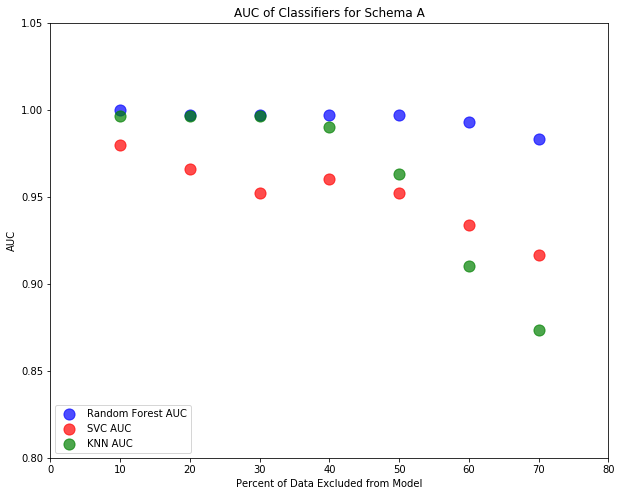

In [319]:

plt.figure(figsize=(10,8))

#percent of data missing from the set on x axis, accuracy on y axis
plt.scatter([10, 20, 30, 40, 50, 60, 70], rf_auc, marker='o', color='b', alpha=0.7,
            s = 124, label='Random Forest AUC')

plt.scatter([10, 20, 30, 40, 50, 60, 70], svc_auc, marker='o', color='r', alpha=0.7, 
            s = 124, label='SVC AUC')

plt.scatter([10, 20, 30, 40, 50, 60, 70], knn_auc, marker='o', color='g', alpha=0.7, 
            s = 124, label='KNN AUC')
plt.title("AUC of Classifiers for Schema A")
plt.xlabel("Percent of Data Excluded from Model")
plt.ylabel("AUC")
plt.xlim(0, 80)
plt.ylim(0.8, 1.05)
plt.legend(loc='lower left')
plt.show()

In [282]:
#for baptiste's model: 
#use big_df
X = big_df.loc[:, big_df.columns != "diversion"]
y = big_df["diversion"]
trucks_train, trucks_test, diversion_train, diversion_test = train_test_split(X, y, test_size=0.3)

missing = []
for p in range(1, 8): 
    missing.append(mask(X, p * 0.1))

In [283]:
scaler = StandardScaler()
train_test = []
scaled = []
for m in missing: 
    train_test.append(train_test_split(m, big_df["diversion"], test_size=0.3))
    mscaled = scaler.fit_transform(m)
    scaled.append(train_test_split(mscaled, big_df["diversion"], test_size = 0.3))
  

In [289]:
rf_accuracy = []
rf_auc = []
for trucks_train, trucks_test, diversion_train, diversion_test in train_test: 
    rf = RandomForestClassifier(n_estimators=3)
    rf.fit(trucks_train, diversion_train)

    rfy_pred = rf.predict(trucks_test)
    rf_accuracy.append(metrics.accuracy_score(diversion_test, rfy_pred))
    rf_auc.append(metrics.roc_auc_score(diversion_test, rfy_pred))
    print("Random forest accuracy:",metrics.accuracy_score(diversion_test, rfy_pred))
    print("Random forest auc:",metrics.roc_auc_score(diversion_test, rfy_pred))
    print("Random forest confusion matrix:", metrics.confusion_matrix(diversion_test, rfy_pred))
    print()
    
print(rf_accuracy)
print(rf_auc)

Random forest accuracy: 1.0
Random forest auc: 1.0
Random forest confusion matrix: [[139   0]
 [  0 161]]

Random forest accuracy: 1.0
Random forest auc: 1.0
Random forest confusion matrix: [[142   0]
 [  0 158]]

Random forest accuracy: 0.9966666666666667
Random forest auc: 0.9968354430379747
Random forest confusion matrix: [[142   0]
 [  1 157]]

Random forest accuracy: 1.0
Random forest auc: 1.0
Random forest confusion matrix: [[147   0]
 [  0 153]]

Random forest accuracy: 0.9966666666666667
Random forest auc: 0.9963503649635037
Random forest confusion matrix: [[136   1]
 [  0 163]]

Random forest accuracy: 0.9966666666666667
Random forest auc: 0.9963503649635037
Random forest confusion matrix: [[136   1]
 [  0 163]]

Random forest accuracy: 0.99
Random forest auc: 0.990909090909091
Random forest confusion matrix: [[135   0]
 [  3 162]]

[1.0, 1.0, 0.9966666666666667, 1.0, 0.9966666666666667, 0.9966666666666667, 0.99]
[1.0, 1.0, 0.9968354430379747, 1.0, 0.9963503649635037, 0.996350

In [291]:
svc_accuracy = []
svc_auc = []
knn_accuracy = []
knn_auc = []
for s_trucks_train, s_trucks_test, diversion_train, diversion_test in scaled:
    svc = svm.SVC()
    svc.fit(s_trucks_train, diversion_train)
    svc_yhat = svc.predict(s_trucks_test)
    svc_accuracy.append(metrics.accuracy_score(diversion_test, svc_yhat))
    svc_auc.append(metrics.roc_auc_score(diversion_test, svc_yhat))
    print("SVC accuracy:", metrics.accuracy_score(diversion_test, svc_yhat))
    print("SVC auc:",metrics.roc_auc_score(diversion_test, svc_yhat))
    print("SVC confusion matrix:", metrics.confusion_matrix(diversion_test, svc_yhat))
    print()
    
    knn = neighbors.KNeighborsClassifier(3, weights = 'uniform')   
    model = knn.fit(s_trucks_train, diversion_train)
    print(model.score(s_trucks_train, diversion_train))

    knnhat = model.predict(s_trucks_test)
    knn_accuracy.append(metrics.accuracy_score(diversion_test, knnhat))
    knn_auc.append(metrics.roc_auc_score(diversion_test, knnhat))
    print("KNN test accuracy:", metrics.accuracy_score(diversion_test, knnhat))
    print("KNN auc:",metrics.roc_auc_score(diversion_test, knnhat))
    print("KNN confusion matrix:", metrics.confusion_matrix(diversion_test, knnhat))
    print()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 1.0
SVC auc: 1.0
SVC confusion matrix: [[145   0]
 [  0 155]]

0.9985714285714286
KNN test accuracy: 1.0
KNN auc: 1.0
KNN confusion matrix: [[145   0]
 [  0 155]]

SVC accuracy: 1.0
SVC auc: 1.0
SVC confusion matrix: [[149   0]
 [  0 151]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9914285714285714
KNN test accuracy: 0.9733333333333334
KNN auc: 0.9735099337748344
KNN confusion matrix: [[149   0]
 [  8 143]]

SVC accuracy: 1.0
SVC auc: 1.0
SVC confusion matrix: [[137   0]
 [  0 163]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9842857142857143
KNN test accuracy: 0.9466666666666667
KNN auc: 0.9509202453987731
KNN confusion matrix: [[137   0]
 [ 16 147]]

SVC accuracy: 1.0
SVC auc: 1.0
SVC confusion matrix: [[154   0]
 [  0 146]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9771428571428571
KNN test accuracy: 0.95
KNN auc: 0.9486301369863014
KNN confusion matrix: [[154   0]
 [ 15 131]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 0.9966666666666667
SVC auc: 0.9967320261437909
SVC confusion matrix: [[147   0]
 [  1 152]]

0.9557142857142857
KNN test accuracy: 0.9466666666666667
KNN auc: 0.9477124183006536
KNN confusion matrix: [[147   0]
 [ 16 137]]

SVC accuracy: 1.0
SVC auc: 1.0
SVC confusion matrix: [[145   0]
 [  0 155]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9242857142857143
KNN test accuracy: 0.8533333333333334
KNN auc: 0.8580645161290323
KNN confusion matrix: [[145   0]
 [ 44 111]]



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 0.9833333333333333
SVC auc: 0.9838206453913354
SVC confusion matrix: [[154   4]
 [  1 141]]

0.8585714285714285
KNN test accuracy: 0.7966666666666666
KNN auc: 0.7852112676056338
KNN confusion matrix: [[158   0]
 [ 61  81]]



In [293]:
print(knn_accuracy)
print(svc_accuracy)

[1.0, 0.9733333333333334, 0.9466666666666667, 0.95, 0.9466666666666667, 0.8533333333333334, 0.7966666666666666]
[1.0, 1.0, 1.0, 1.0, 0.9966666666666667, 1.0, 0.9833333333333333]


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

#percent of data missing from the set on x axis, accuracy on y axis
plt.scatter([10, 20, 30, 40, 50, 60, 70], rf_accuracy, marker='o', color='b', alpha=0.7,
            s = 124, label='Random Forest Classifier')

plt.scatter([10, 20, 30, 40, 50, 60, 70], svc_accuracy, marker='o', color='r', alpha=0.7, 
            s = 124, label='Support Vector Classifier')

plt.scatter([10, 20, 30, 40, 50, 60, 70], knn_accuracy, marker='o', color='g', alpha=0.7, 
            s = 124, label='K-Nearest Neighbors Classifier')
plt.title("Accuracy of Classifiers for Schema B")
plt.xlabel("Percent of Data Excluded from Model")
plt.ylabel("Accuracy")
plt.xlim(0, 80)
plt.ylim(0.75, 1.05)
plt.legend(loc='lower left')
plt.show()

NameError: name 'rf_accuracy' is not defined

<Figure size 720x576 with 0 Axes>

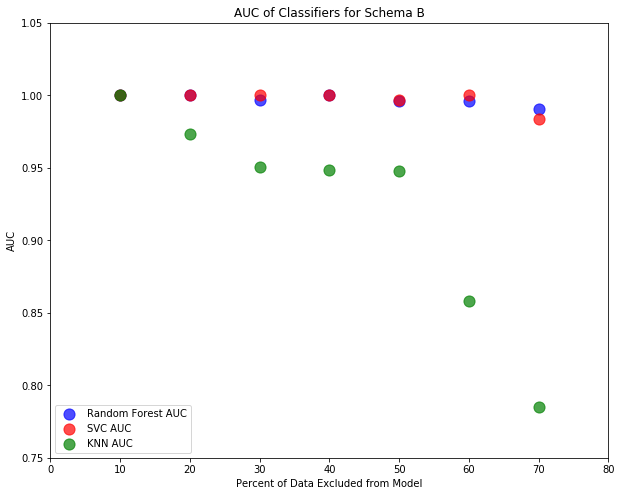

In [303]:
plt.figure(figsize=(10,8))

#percent of data missing from the set on x axis, accuracy on y axis
plt.scatter([10, 20, 30, 40, 50, 60, 70], rf_auc, marker='o', color='b', alpha=0.7,
            s = 124, label='Random Forest AUC')

plt.scatter([10, 20, 30, 40, 50, 60, 70], svc_auc, marker='o', color='r', alpha=0.7, 
            s = 124, label='SVC AUC')

plt.scatter([10, 20, 30, 40, 50, 60, 70], knn_auc, marker='o', color='g', alpha=0.7, 
            s = 124, label='KNN AUC')
plt.title("AUC of Classifiers for Schema B")
plt.xlabel("Percent of Data Excluded from Model")
plt.ylabel("AUC")
plt.xlim(0, 80)
plt.ylim(0.75, 1.05)
plt.legend(loc='lower left')
plt.show()